In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv("../2330.TW_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[23:]
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-03,103.0,103.0,102.0,102.5,75.244667,38599000
2014-01-06,102.0,103.0,102.0,102.5,75.244667,23706000
2014-01-07,102.5,103.0,102.0,102.0,74.877609,15836000
2014-01-08,103.0,104.5,102.5,104.0,76.345802,30218000
2014-01-09,102.5,103.0,100.5,101.0,74.143509,63998000
...,...,...,...,...,...,...
2023-12-25,582.0,585.0,580.0,581.0,573.515503,9548143
2023-12-26,583.0,586.0,582.0,586.0,578.451111,16094308
2023-12-27,587.0,592.0,586.0,592.0,584.373840,33401336


In [3]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(data_trend, train_ratio, n_past, predict_day):
    scaler = MinMaxScaler()  
    print(data_trend.shape)
    data_trend = scaler.fit_transform(data_trend)
    
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day, 3])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data = df[[c for c in df.columns if c not in ['Date','Adj Close','Volume']]].values
train_ratio = 0.9
test_val_ratio = 0.9
n_past = 40     #移動視窗大小
predict_day = 10 #要預測後面幾天
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = preprocess(data, train_ratio, n_past, predict_day)
batch_size = 32

train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


(2439, 4)


In [4]:

class BiLSTM(nn.Module):
    def __init__(self, n_features, hidden_dim, predict_day):
        super(BiLSTM, self).__init__()
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.predict_day = predict_day
        
        self.lstm = nn.LSTM(input_size=self.n_features, hidden_size=self.hidden_dim, 
                            num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(self.hidden_dim * 2, self.predict_day)
        
    def forward(self, x): 
        x, _ = self.lstm(x)
        x = self.linear(x[:,-1,:]) #取最後一個state
        
        return x


In [5]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# 檢查是否有可用的GPU
if torch.cuda.is_available():
    print("GPU")
    device = torch.device("cuda")  # 使用GPU
else:
    print("CPU")
    device = torch.device("cpu")  # 使用CPU
# 設置訓練參數
num_epochs = 100
learning_rate = 0.001

# 初始化模型、損失函數和優化器
model = BiLSTM(n_features=4, hidden_dim=128, predict_day=10)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

GPU


In [6]:
# 記錄每個 epoch 的損失值
train_losses = []
val_losses = []
min_val_loss = float('inf')
best_model_path = "bilstm_10.pth"

# 訓練模型
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch= x_batch.to(device)
        y_batch= y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # 驗證模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch= x_batch.to(device)
            y_batch= y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    '''
    if val_loss < min_val_loss and epoch>50:
        min_val_loss = val_loss
        torch.save(model, best_model_path) 
        print(f"Model saved with val_loss: {val_loss:.4f}")
    '''
    # 打印每個epoch的訓練和驗證損失
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    torch.save(model, best_model_path)



Epoch [1/100], Train Loss: 0.0072, Val Loss: 0.0053
Epoch [2/100], Train Loss: 0.0255, Val Loss: 0.0023
Epoch [3/100], Train Loss: 0.0490, Val Loss: 0.0049
Epoch [4/100], Train Loss: 0.0637, Val Loss: 0.0762
Epoch [5/100], Train Loss: 0.0238, Val Loss: 0.0011
Epoch [6/100], Train Loss: 0.0026, Val Loss: 0.0015
Epoch [7/100], Train Loss: 0.0011, Val Loss: 0.0009
Epoch [8/100], Train Loss: 0.0006, Val Loss: 0.0007
Epoch [9/100], Train Loss: 0.0006, Val Loss: 0.0006
Epoch [10/100], Train Loss: 0.0006, Val Loss: 0.0006
Epoch [11/100], Train Loss: 0.0007, Val Loss: 0.0008
Epoch [12/100], Train Loss: 0.0008, Val Loss: 0.0008
Epoch [13/100], Train Loss: 0.0011, Val Loss: 0.0014
Epoch [14/100], Train Loss: 0.0014, Val Loss: 0.0016
Epoch [15/100], Train Loss: 0.0015, Val Loss: 0.0017
Epoch [16/100], Train Loss: 0.0027, Val Loss: 0.0021
Epoch [17/100], Train Loss: 0.0033, Val Loss: 0.0013
Epoch [18/100], Train Loss: 0.0050, Val Loss: 0.0036
Epoch [19/100], Train Loss: 0.0064, Val Loss: 0.0136
Ep

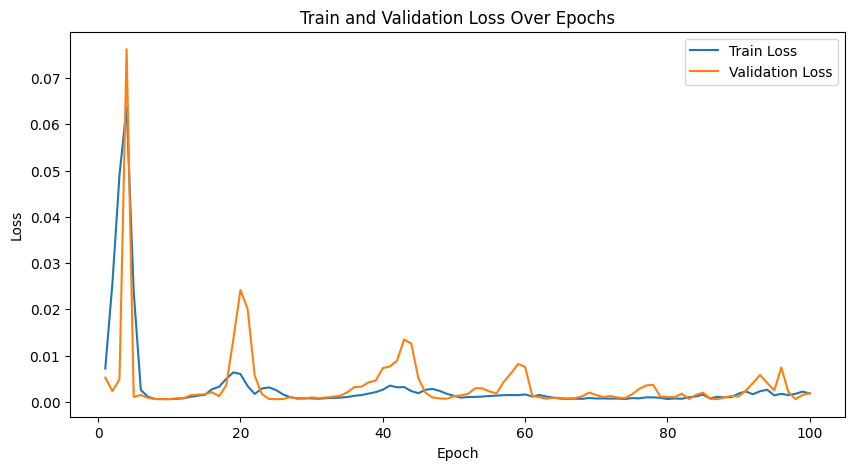

In [7]:
import matplotlib.pyplot as plt
# 繪製損失走勢圖
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100+1), train_losses, label='Train Loss')
plt.plot(range(1, 100+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.show()

In [8]:
print(len(Y_test))
close_price_true = []
temp_real = []
real = Y_test.detach().cpu().numpy()
for i in range(len(Y_test)):
   temp_real.append(real[i][0])
temp_real = np.array(temp_real)
temp_real = temp_real.reshape(-1, 1)
temp_real = np.repeat(temp_real, 4, axis=1)
# print(close_price_true)
temp_real = scaler.inverse_transform(temp_real)
# print(temp_real)
for i in range(len(temp_real)):
   close_price_true.append(temp_real[i][3])

195


[543.68994, 545.2739, 543.8208, 546.23145, 538.26483, 538.29504, 536.2972, 537.6826, 532.0232, 540.2625, 538.93604, 539.4324, 550.0458, 553.91437, 556.81665, 553.1914, 547.65625, 551.1462, 554.9913, 555.32294, 550.39557, 552.94574, 551.7671, 546.11334, 543.8801, 537.56323, 540.22314, 542.0689, 540.6987, 538.0091, 537.35236, 539.448, 532.4388, 527.8933, 522.6279, 520.53876, 527.4455, 527.24603, 523.9408, 524.9734, 527.185, 532.0694, 533.71594, 530.8505, 528.712, 524.18115, 524.1037, 530.3915, 538.17285, 552.3901, 553.5105, 551.90735, 550.0307, 547.8616, 560.29816, 579.0568, 581.5951, 577.87335, 571.8035, 567.0779, 574.232, 572.2319, 571.7466, 576.95123, 574.55695, 576.1061, 583.61755, 597.14594, 595.2037, 595.2962, 594.0088, 590.47046, 589.19147, 589.2159, 585.06854, 582.0061, 585.19965, 584.9785, 582.9192, 586.9983, 591.0011, 591.61, 580.30975, 577.95184, 579.1794, 584.5571, 585.2623, 593.0197, 595.0944, 594.77954, 590.8694, 589.98895, 588.3831, 573.6782, 572.44727, 577.5556, 579.36084

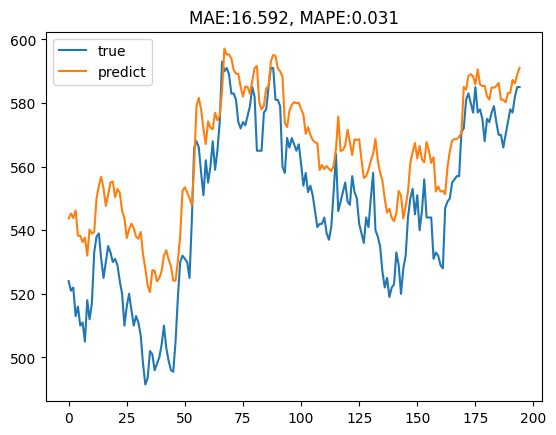

In [9]:
# model = torch.load("model.pt")
# len(test_set)
import matplotlib.pyplot as plt
close_price_pred = []
model = torch.load('bilstm_10.pth')
model.to(device)
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device))
    pred = pred.detach().cpu().numpy()[0]
    pred = pred.reshape(-1, 1)
    # print(pred)
    pred = np.repeat(pred, 4, axis=1)
    pred_inver = scaler.inverse_transform(pred)
    # print(pred_inver[0][0])
    close_price_pred.append(pred_inver[0][3])
print(close_price_pred)
mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}'.format(mae, mape))
plt.legend(['true', 'predict'])

In [10]:
def preprocess(data_trend, train_ratio, n_past, predict_day):     
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day, 3])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data2 = df[[c for c in df.columns if c not in ['Date','Adj Close','Volume']]].values
X_train, Y_train, X_val, Y_val, X_test, Y_test = preprocess(data2, train_ratio, n_past, predict_day)
Y_test.shape

torch.Size([195, 10])

In [11]:
print(Y_test.shape)
pred_arr = []
#len(test_set)
arr = []
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device))
    pred = pred.detach().cpu().numpy()
    pred = pred.reshape(-1, 1)
    pred = np.repeat(pred, 4, axis=1)
    # print(pred)
    pred_inver = scaler.inverse_transform(pred)
    # print(pred_inver[:, 3])
    pred_arr.append(pred_inver[:, 3])
pred_arr = np.array(pred_arr)
pred_arr = torch.tensor(pred_arr)

torch.Size([195, 10])


In [12]:
mae = torch.mean(torch.abs(pred_arr - Y_test))
mape = torch.mean(torch.abs(pred_arr - Y_test)/Y_test)
print(f"mae: {mae.item()}")
print(f"mape: {mape.item()}")

mae: 23.487049102783203
mape: 0.0436994731426239


In [15]:
ma10_f=[]
true=[]
pred=[]
pred_arr = np.array(pred_arr)
Y_test = np.array(Y_test)
for i in range(0,len(pred_arr)):
    true.append(Y_test[i][0])
    ma10_f.append(np.mean(pred_arr[i]))
    pred.append(pred_arr[i][0])
newdf = pd.DataFrame({'True':true, 'Pred':pred, 'MA10_F':ma10_f})
newdf

,True,Pred,MA10_F
0,524.0,506.233368,512.925720
1,521.0,507.776123,514.322632
2,522.0,506.576935,513.204285
3,513.0,509.869354,516.414734
4,516.0,501.176178,508.210632
...,...,...,...
190,578.0,556.093628,562.040588
191,577.0,560.016663,565.757690
192,582.0,560.809143,566.437683
193,585.0,560.113159,565.936951


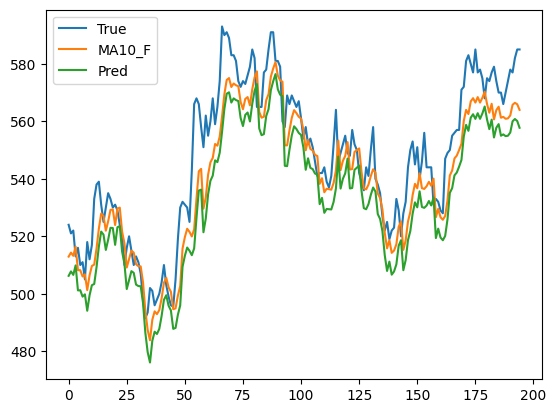

In [16]:
plt.plot(newdf['True'])
plt.plot(newdf['MA10_F'])
plt.plot(newdf['Pred'])
plt.legend(['True','MA10_F','Pred'])

In [17]:
cash=1000000 #初始資金100w
position=0 #持倉
buy_flag=0
def mothod(true, ma10_f, cash, position, buy_flag):
    income=[]
    buy_flag_arr=[]
    for i in range(1, len(true)):
        if i==0:
            cash=1000000
        elif i==len(true)-1 and position==1:
            cash=cash+position*true[i-1]*1000 #賣
            position=0
            buy_flag=-1
        else:
            if (ma10_f[i]-true[i-1])>=0 and position==0: #預測漲且沒有持倉
                position=1 #買
                entry_price = true[i-1]
                cash=cash-position*entry_price*1000
                buy_flag=1
            elif (ma10_f[i]-true[i-1])<0 and position==1:
                cash=cash+position*true[i-1]*1000 #賣
                position=0
                buy_flag=-1
            else:
                buy_flag=0
        print(i,cash,buy_flag)
        income.append(cash)
        buy_flag_arr.append(buy_flag)
    return income,buy_flag_arr
        # print(position)


money, buy_flag_arr = mothod(newdf['True'], newdf['MA10_F'], cash, position, buy_flag)

1 1000000 0
2 1000000 0
3 1000000 0
4 1000000 0
5 1000000 0
6 1000000 0
7 1000000 0
8 1000000 0
9 1000000 0
10 1000000 0
11 1000000 0
12 1000000 0
13 1000000 0
14 1000000 0
15 1000000 0
16 1000000 0
17 1000000 0
18 1000000 0
19 1000000 0
20 1000000 0
21 1000000 0
22 471000.0 1
23 995000.0 -1
24 995000.0 0
25 995000.0 0
26 995000.0 0
27 995000.0 0
28 995000.0 0
29 485000.0 1
30 998000.0 -1
31 998000.0 0
32 998000.0 0
33 998000.0 0
34 998000.0 0
35 998000.0 0
36 998000.0 0
37 998000.0 0
38 998000.0 0
39 998000.0 0
40 998000.0 0
41 998000.0 0
42 998000.0 0
43 998000.0 0
44 499000.0 1
45 995000.0 -1
46 995000.0 0
47 995000.0 0
48 995000.0 0
49 995000.0 0
50 995000.0 0
51 995000.0 0
52 995000.0 0
53 995000.0 0
54 995000.0 0
55 995000.0 0
56 995000.0 0
57 995000.0 0
58 995000.0 0
59 995000.0 0
60 995000.0 0
61 995000.0 0
62 995000.0 0
63 995000.0 0
64 995000.0 0
65 995000.0 0
66 995000.0 0
67 995000.0 0
68 995000.0 0
69 995000.0 0
70 995000.0 0
71 995000.0 0
72 995000.0 0
73 995000.0 0
74 99

In [18]:
cash=1000000 #初始資金100w
position=0 #持倉
buy_flag=0
def mothod(true, pred, cash, position, buy_flag):
    income=[]
    buy_flag_arr=[]
    for i in range(1, len(true)):
        if i==0:
            cash=1000000
        elif i==len(true)-1 and position==1:
            cash=cash+position*true[i-1]*1000 #賣
            position=0
            buy_flag=-1
        else:
            if (pred[i]-true[i-1])>=0 and position==0: #預測漲且沒有持倉
                position=1 #買
                entry_price = true[i-1]
                cash=cash-position*entry_price*1000
                buy_flag=1
            elif (pred[i]-true[i-1])<0 and position==1:
                cash=cash+position*true[i-1]*1000 #賣
                position=0
                buy_flag=-1
            else:
                buy_flag=0
        print(i,cash,buy_flag)
        income.append(cash)
        buy_flag_arr.append(buy_flag)
    return income,buy_flag_arr
        # print(position)


money, buy_flag_arr = mothod(newdf['True'], newdf['Pred'], cash, position, buy_flag)

1 1000000 0
2 1000000 0
3 1000000 0
4 1000000 0
5 1000000 0
6 1000000 0
7 1000000 0
8 1000000 0
9 1000000 0
10 1000000 0
11 1000000 0
12 1000000 0
13 1000000 0
14 1000000 0
15 1000000 0
16 1000000 0
17 1000000 0
18 1000000 0
19 1000000 0
20 1000000 0
21 1000000 0
22 1000000 0
23 1000000 0
24 1000000 0
25 1000000 0
26 1000000 0
27 1000000 0
28 1000000 0
29 1000000 0
30 1000000 0
31 1000000 0
32 1000000 0
33 1000000 0
34 1000000 0
35 1000000 0
36 1000000 0
37 1000000 0
38 1000000 0
39 1000000 0
40 1000000 0
41 1000000 0
42 1000000 0
43 1000000 0
44 1000000 0
45 1000000 0
46 1000000 0
47 1000000 0
48 1000000 0
49 1000000 0
50 1000000 0
51 1000000 0
52 1000000 0
53 1000000 0
54 1000000 0
55 1000000 0
56 1000000 0
57 1000000 0
58 1000000 0
59 1000000 0
60 1000000 0
61 1000000 0
62 1000000 0
63 1000000 0
64 1000000 0
65 1000000 0
66 1000000 0
67 1000000 0
68 1000000 0
69 1000000 0
70 1000000 0
71 1000000 0
72 1000000 0
73 1000000 0
74 1000000 0
75 1000000 0
76 1000000 0
77 1000000 0
78 10000

In [11]:

mae = torch.mean(torch.abs(pred_arr[:,9] - Y_test[:,9]))
mape = torch.mean(torch.abs(pred_arr[:,9] - Y_test[:,9])/Y_test[:,9])
print(f"mae: {mae.item()}")
print(f"mape: {mape.item()}")

mae: 18.032291412353516
mape: 0.0325997918844223


In [12]:
import csv

with open('ex2output.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    rows = list(reader)

for i in range(len(pred_arr[:,0])):
    rows[i].append(pred_arr[:,0][i].item())

# 寫回檔案
with open('ex2output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)


